# Introduction
- nb47のfcの解析
- fcとその他の特徴量の交互相互作用を作成し、`scalar_coupling_constant`との相関を見る
- 特徴量は、標準化あり、なしを試す
- type ごとも試す

# Import everything I need :)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from fastprogress import progress_bar

# Preparation

In [2]:
nb = 68
isSmallSet = False
length = 20000

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [5]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/structures.zip',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.cs

In [6]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [7]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [8]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [9]:
# fc_train
path = file_path + 'nb47_fc_train.csv'
if isSmallSet:
    fc_train = pd.read_csv(path)[:length]
else:
    fc_train = pd.read_csv(path)

In [10]:
# fc_test
path = file_path + 'nb47_fc_test.csv'
if isSmallSet:
    fc_test = pd.read_csv(path)[:length]
else:
    fc_test = pd.read_csv(path)

In [11]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [12]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [13]:
# ob charge train
path = file_path + 'train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_train = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_train = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [14]:
# ob charge test
path = file_path + 'test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_test = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_test = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [15]:
len(test), len(fc_test)

(2505542, 2505542)

In [16]:
len(train), len(fc_train)

(4658147, 4658147)

In [17]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [18]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = model.predict(df_perm)
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Feature Engineering

Build Distance Dataset

In [21]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_name'].isin(base['molecule_name'])]
    return base, structures

# a,b = build_type_dataframes(train, structures, '1JHN')

In [22]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [23]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

In [24]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_name'],
                  right_on=['molecule_name'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [25]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [26]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [27]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_name'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_name', right_index=True)

In [28]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_name', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_name', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_name', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
#     # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
#     atoms['molecule_name'] = atoms['molecule_name'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [29]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['id', 'molecule_name', 'atom_index_1', 'atom_index_0']
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [30]:
atoms = structures['atom'].values
types_train = train['type'].values
types_test = test['type'].values
structures['atom'] = structures['atom'].replace(ATOMIC_NUMBERS).astype('int8')
fulls_train = []
fulls_test  = []
for type_ in progress_bar(train['type'].unique()):
    full_train = build_couple_dataframe(train, structures, type_, n_atoms=10)
    full_test  = build_couple_dataframe(test, structures, type_, n_atoms=10)
    full_train = take_n_atoms(full_train, 10)
    full_test  = take_n_atoms(full_test, 10)
    fulls_train.append(full_train)
    fulls_test.append(full_test)
    
structures['atom'] = atoms
train = pd.concat(fulls_train).sort_values(by=['id']) #, axis=0)
test  = pd.concat(fulls_test).sort_values(by=['id']) #, axis=0)
train['type'] = types_train
test['type'] = types_test
train = train.fillna(0)
test  = test.fillna(0)

<br>
<br>
dist-interact

In [31]:
train['dist_interact'] = dist_interact_train.values
test['dist_interact'] = dist_interact_test.values

<br>
<br>
basic

In [32]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df


# structure and ob_charges
ob_charge = pd.concat([ob_charge_train, ob_charge_test])
merge = pd.merge(ob_charge, structures, how='left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
for atom_idx in [0,1]:
    train = map_atom_info(train, merge, atom_idx)
    test  = map_atom_info(test,  merge, atom_idx)
    
    train = train.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}',
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}',})
    test = test.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}', 
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}'})
#     test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
#                                         'x': f'x_{atom_idx}',
#                                         'y': f'y_{atom_idx}',
#                                         'z': f'z_{atom_idx}'})

# ob_charges
# train = map_atom_info(train, ob_charge_train, 0)
# test  = map_atom_info(test,  ob_charge_test,  0)
# train = map_atom_info(train, ob_charge_train, 1)
# test  = map_atom_info(test,  ob_charge_test,  1)

<br>
<br>
type0

In [33]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df
# train['type_0'] = train['type'].apply(lambda x: x[0])
# test['type_0'] = test['type'].apply(lambda x: x[0])

<br>
<br>
distances

In [34]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

<br>
<br>
統計量

In [35]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    # fc
    df[f'molecule_type_fc_max'] = df.groupby(['molecule_name', 'type'])['fc'].transform('max')
    df[f'molecule_type_fc_min'] = df.groupby(['molecule_name', 'type'])['fc'].transform('min')
    df[f'molecule_type_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
    df[f'molecule_type_fc_std_diff'] = df[f'molecule_type_fc_std'] - df['fc']
    df[f'molecule_atom_index_0_fc_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('mean')
    df[f'molecule_atom_index_0_fc_mean_diff'] = df[f'molecule_atom_index_0_fc_mean'] - df['fc']
    df[f'molecule_atom_index_0_fc_mean_div'] = df[f'molecule_atom_index_0_fc_mean'] / df['dist']
    df[f'molecule_atom_index_0_fc_max'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('max')
    df[f'molecule_atom_index_0_fc_max_diff'] = df[f'molecule_atom_index_0_fc_max'] - df['fc']
    df[f'molecule_atom_index_0_fc_max_div'] = df[f'molecule_atom_index_0_fc_max'] / df['fc']
    df[f'molecule_atom_index_0_fc_min'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('min')
    df[f'molecule_atom_index_0_fc_min_diff'] = df[f'molecule_atom_index_0_fc_min'] - df['fc']
    df[f'molecule_atom_index_0_fc_min_div'] = df[f'molecule_atom_index_0_fc_min'] / df['fc']
    df[f'molecule_atom_index_0_fc_std'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('std')
    df[f'molecule_atom_index_0_fc_std_diff'] = df[f'molecule_atom_index_0_fc_std'] - df['fc']
    df[f'molecule_atom_index_0_fc_std_div'] = df[f'molecule_atom_index_0_fc_std'] / df['fc']
    df[f'molecule_atom_index_1_fc_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('mean')
    df[f'molecule_atom_index_1_fc_mean_diff'] = df[f'molecule_atom_index_1_fc_mean'] - df['fc']
    df[f'molecule_atom_index_1_fc_mean_div'] = df[f'molecule_atom_index_1_fc_mean'] / df['fc']
    df[f'molecule_atom_index_1_fc_max'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('max')
    df[f'molecule_atom_index_1_fc_max_diff'] = df[f'molecule_atom_index_1_fc_max'] - df['fc']
    df[f'molecule_atom_index_1_fc_max_div'] = df[f'molecule_atom_index_1_fc_max'] / df['fc']
    df[f'molecule_atom_index_1_fc_min'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('min')
    df[f'molecule_atom_index_1_fc_min_diff'] = df[f'molecule_atom_index_1_fc_min'] - df['fc']
    df[f'molecule_atom_index_1_fc_min_div'] = df[f'molecule_atom_index_1_fc_min'] / df['fc']
    df[f'molecule_atom_index_1_fc_std'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('std')
    df[f'molecule_atom_index_1_fc_std_diff'] = df[f'molecule_atom_index_1_fc_std'] - df['fc']
    df[f'molecule_atom_index_1_fc_std_div'] = df[f'molecule_atom_index_1_fc_std'] / df['fc']
  
    return df

angle features

In [36]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [37]:
%%time

print('add fc')
print(len(train), len(test))
train['fc'] = fc_train.values
test['fc']  = fc_test.values

print('type0')
print(len(train), len(test))
train = create_type0(train)
test  = create_type0(test)

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)
train.drop_duplicates(inplace=True, subset=['id'])   # なぜかtrainの行数が増えるバグが発生
train = train.reset_index(drop=True)

print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

add fc
4658147 2505542
type0
4658147 2505542
distances
4658147 2505542
create_featueres
4658147 2505542
create_closest
4658147 2505542
add_cos_features
4658147 2505542
CPU times: user 6min 29s, sys: 8min 59s, total: 15min 29s
Wall time: 15min 29s


---
<br>
<br>
<br>
nanがある特徴量を削除

In [38]:
drop_feats = train.columns[train.isnull().sum(axis=0) != 0].values
drop_feats

array(['dist_interact', 'molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean_div',
       'molecule_atom_index_0_y_1_std', 'molecule_atom_index_0_z_1_std',
       'molecule_atom_index_0_dist_std',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div',
       'molecule_atom_index_1_dist_std',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_std',
       'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std',
       'molecule_type_0_dist_std_diff', 'molecule_type_dist_std',
       'molecule_type_dist_std_diff', 'molecule_type_fc_std',
       'molecule_type_fc_std_diff', 'molecule_atom_index_0_fc_std',
       'molecule_atom_index_0_fc_std_diff',
       'molecule_atom_index_0_fc_std_div', 'molecule_atom_index_1_fc_std',
       'molecule_atom_index_1_fc_std_diff',
       'molecule_atom_index_1_fc_std_div'], dtype=object)

In [39]:
train = train.drop(drop_feats, axis=1)
test  = test.drop(drop_feats, axis=1)

assert sum(train.isnull().sum(axis=0))==0, f'train に nan があります。'
assert sum(test.isnull().sum(axis=0))==0,  f'test に nan があります。'

<br>
<br>
<br>
エンコーディング

In [40]:
cat_cols = ['atom_1']
num_cols = list(set(train.columns) - set(cat_cols) - set(['type', "scalar_coupling_constant", 'molecule_name', 'id',
                                                          'atom_0', 'atom_1','atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']))
                
print(f'カテゴリカル: {cat_cols}')
print(f'数値:        {num_cols}')

カテゴリカル: ['atom_1']
数値:        ['d_5_1', 'd_9_0', 'molecule_atom_index_1_fc_mean_diff', 'eem2015hn_1', 'molecule_atom_index_1_dist_min_div', 'molecule_atom_index_1_fc_mean', 'eem_1', 'molecule_atom_1_dist_min', 'distance_1', 'molecule_atom_index_0_dist_mean_div', 'molecule_atom_index_1_dist_max_diff', 'molecule_type_dist_min', 'd_3_2', 'molecule_atom_index_1_fc_mean_div', 'd_2_0', 'z_1', 'd_7_0', 'molecule_atom_index_0_fc_mean', 'molecule_type_dist_mean_diff', 'd_7_1', 'qtpie_0', 'molecule_atom_index_0_dist_min_diff', 'molecule_type_fc_max', 'd_3_1', 'eem2015bm_1', 'd_7_3', 'molecule_dist_max', 'd_4_2', 'd_3_0', 'y_closest_0', 'atom_index_0', 'd_2_1', 'molecule_atom_index_0_fc_min', 'mmff94_0', 'molecule_atom_index_1_dist_max', 'eem2015bn_0', 'd_9_2', 'cos_0', 'z_closest_1', 'molecule_atom_index_0_dist_max_diff', 'd_5_3', 'qtpie_1', 'molecule_atom_index_0_dist_mean', 'd_4_3', 'molecule_atom_index_0_dist_min', 'molecule_atom_1_dist_min_diff', 'gasteiger_1', 'molecule_atom_index_1_dist_me

<br>
<br>

---
**show features**

In [41]:
train.head(2)

,id,molecule_name,atom_index_1,atom_index_0,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant,type,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,atom_1,x_1,y_1,z_1,fc,type_0,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_fc_max,molecule_type_fc_min,molecule_atom_index_0_fc_mean,molecule_atom_index_0_fc_mean_diff,molecule_atom_index_0_fc_mean_div,molecule_atom_index_0_fc_max,molecule_atom_index_0_fc_max_diff,molecule_atom_index_0_fc_max_div,molecule_atom_index_0_fc_min,molecule_atom_index_0_fc_min_diff,molecule_atom_index_0_fc_min_div,molecule_atom_index_1_fc_mean,molecule_atom_index_1_fc_mean_diff,molecule_atom_index_1_fc_mean_div,molecule_atom_index_1_fc_max,molecule_atom_index_1_fc_max_diff,molecule_atom_index_1_fc_max_div,molecule_atom_index_1_fc_min,molecule_atom_index_1_fc_min_diff,molecule_atom_index_1_fc_min_div,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,0,1,1,1,1,0,0,0,0,0,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.8076,1JHC,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.00215,-0.006031,0.001976,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,C,-0.012698,1.085804,0.008001,82.734236,1,1.091953,0.000220,1.192105,0.000036,10,1.506668,1.091946,1.783158,4,4,1.358754,0.272949,1.463751,0.377947,1.610344,0.518391,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,1.09195,-0.000003,0.999997,1.091953,0.0,1.0,1.091946,-0.000007,0.999994,1.091950,1.091946,-0.000007,0.999994,1.091950,-0.000003,0.999997,1.091953,1.091946,84.195240,82.285655,12.468657,-70.265579,11.418675,82.734236,0.000000,1.000000,-11.096087,-93.830323,-0.134117,83.303123,0.568888,1.006876,84.195240,1.461004,1.017659,82.285655,-0.448581,0.994578,0,-0.012698,1.085804,0.008001,3,-0.540815,1.447527,-0.876644,1.091953,1.091946,0.333335,-1.000000,-0.333335
1,1,dsgdb9nsd_000001,2,1,6,1,1,0,0,0,0,0,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,1.091946,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.2570,2JHH,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.00215,-0.006031,0.001976,0.161132,0.0,0.01939

In [42]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_1', 'atom_index_0', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       ...
       'z_closest_0', 'atom_index_closest_1', 'x_closest_1', 'y_closest_1',
       'z_closest_1', 'distance_0', 'distance_1', 'cos_0_1', 'cos_0', 'cos_1'],
      dtype='object', length=150)


# create train, test data

In [43]:
y = train['scalar_coupling_constant']
X = train[sorted(num_cols)].copy()
X_test = test[sorted(num_cols)].copy()

X = X.drop(['type_0'], axis=1)
X_test = X_test.drop(['type_0'], axis=1)


In [44]:
del train, test, full_train, full_test

In [45]:
gc.collect()

0

In [46]:
X.head(2)

,atom_0_couples_count,atom_1_couples_count,atom_index_0,atom_index_1,atom_index_closest_0,atom_index_closest_1,cos_0,cos_0_1,cos_1,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,dist,dist_x,dist_y,dist_z,distance_0,distance_1,eem2015ba_0,eem2015ba_1,eem2015bm_0,eem2015bm_1,eem2015bn_0,eem2015bn_1,eem2015ha_0,eem2015ha_1,eem2015hm_0,eem2015hm_1,eem2015hn_0,eem2015hn_1,eem_0,eem_1,fc,gasteiger_0,gasteiger_1,mmff94_0,mmff94_1,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_fc_max,molecule_atom_index_0_fc_max_diff,molecule_atom_index_0_fc_max_div,molecule_atom_index_0_fc_mean,molecule_atom_index_0_fc_mean_diff,molecule_atom_index_0_fc_mean_div,molecule_atom_index_0_fc_min,molecule_atom_index_0_fc_min_diff,molecule_atom_index_0_fc_min_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_fc_max,molecule_atom_index_1_fc_max_diff,molecule_atom_index_1_fc_max_div,molecule_atom_index_1_fc_mean,molecule_atom_index_1_fc_mean_diff,molecule_atom_index_1_fc_mean_div,molecule_atom_index_1_fc_min,molecule_atom_index_1_fc_min_diff,molecule_atom_index_1_fc_min_div,molecule_couples,molecule_dist_max,molecule_dist_mean,molecule_dist_min,molecule_type_dist_max,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_min,molecule_type_fc_max,molecule_type_fc_min,qeq_0,qeq_1,qtpie_0,qtpie_1,x_0,x_1,x_closest_0,x_closest_1,y_0,y_1,y_closest_0,y_closest_1,z_0,z_1,z_closest_0,z_closest_1
0,4,4,1,0,0,3,-1.000000,0.333335,-0.333335,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.091953,0.000220,1.192105,0.000036,1.091953,1.091946,0.016837,-0.067349,0.201583,-0.806339,0.212813,-0.851258,-0.003651,0.014606,0.203254,-0.813021,0.196234,-0.784944,0.161131,-0.644531,82.734236,0.019399,-0.077596,0.0,0.0,1.091950,1.091946,-0.000007,0.999994,1.783157,0.691204,1.632998,1.610344,0.518391,1.474738,1.091953,0.000000,1.000000,82.734236,0.000000,1.000000,12.468657,-70.265579,11.418675,-11.096087,-93.830323,-0.134117,1.463751,0.377947,1.358754,0.272949,1.091953,0.0,1.0,1.09195,-0.000003,0.999997,1.091946,-0.000007,0.999994,84.195240,1.461004,1.017659,83.303123,0.568888,1.006876,82.285655,-0.448581,0.994578,10,1.783158,1.506668,1.091946,1.091953,1.091950,-0.000003,0.999997,1.091946,84.195240,82.285655,-0.812772,3.251140,0.773439,-3.093807,0.00215,-0.012698,-0.012698,-0.540815,-0.006031,1.085804,1.085804,1.447527,0.001976,0.008001,0.008001,-0.876644
1,4,1,1,2,0,0,-0.816483,-0.333287,0.816482,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,1.091946,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.783120,1.019253,2.160261,0.000003,1.091953,1.091952,0.016837,0.016837,0.201583,0.201584,0.212813,0.212813,-0.003651,-0.003651,0.203254,0.203254,0.196234,0.196235,0.161131,0.161132,-10.987318,0.019399,0.019399,0.0,0.0,1.783146,1.783120,0.000000,1.000000,1.783157,0.000037,1.000021,1.610344,-0.172776,0.903105,1.091953,-0.691167,0.6123

# 標準化なし

In [62]:
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
print(f'fcとscalar_coupling_constantの相関係数: {fc_corr}')

fcとscalar_coupling_constantの相関係数: 0.9997973511920173


<br>
<br>
sum  

In [63]:
# compute
operation = 'sum'
corr_sum = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values + X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_sum[f'fc+{feat}'] = corr
corr_sum = corr_sum.drop(['operation'], axis=1) 

In [90]:
# ranking
cols = corr_sum.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_sum[cols]

,fc+molecule_atom_index_0_dist_mean_div,fc+molecule_atom_index_0_dist_min_div,fc+molecule_atom_index_0_dist_max_div,fc+molecule_atom_1_dist_min_div,fc+molecule_atom_index_1_dist_mean_div,fc+molecule_type_dist_mean_div,fc+eem2015bm_0,fc+fc,fc+molecule_dist_min,fc+eem_0,fc+eem2015hm_0,fc+molecule_dist_max,fc+eem2015bn_0,fc+eem2015hn_0,fc+molecule_dist_mean,fc+molecule_atom_index_1_dist_min_div,fc+molecule_type_dist_mean_diff,fc+eem2015ba_0,fc+molecule_atom_index_1_dist_max_div,fc+eem2015ha_0,fc+gasteiger_0,fc+distance_0,fc+molecule_atom_index_0_dist_min,fc+mmff94_0,fc+gasteiger_1,fc+cos_0,fc+molecule_atom_1_dist_mean,fc+molecule_atom_index_0_dist_mean,fc+qtpie_0,fc+molecule_atom_index_0_dist_max,fc+molecule_atom_index_0_dist_mean_diff,fc+molecule_atom_index_0_dist_max_diff,fc+molecule_atom_1_dist_min,fc+d_3_2,fc+eem_1,fc+mmff94_1,fc+molecule_atom_index_0_dist_min_diff,fc+molecule_atom_index_1_dist_mean_diff,fc+eem2015bm_1,fc+eem2015bn_1,fc+eem2015hn_1,fc+qeq_0,fc+eem2015hm_1,fc+eem2015ba_1,fc+molecule_atom_index_1_dist_max_diff,fc+d_2_1,fc+d_4_0,fc+molecule_atom_index_1_dist_mean,fc+distance_1,fc+d_4_2,fc+d_5_0,fc+eem2015ha_1,fc+d_5_2,fc+d_6_2,fc+molecule_atom_1_dist_min_diff,fc+d_3_0,fc+d_7_2,fc+molecule_type_dist_min,fc+d_6_0,fc+d_2_0,fc+cos_0_1,fc+d_8_2,fc+d_5_1,fc+molecule_atom_index_1_dist_min,fc+d_4_1,fc+d_3_1,fc+d_7_0,fc+molecule_atom_index_1_dist_max,fc+d_9_2,fc+cos_1,fc+d_4_3,fc+molecule_atom_index_1_dist_min_diff,fc+d_6_1,fc+d_8_0,fc+molecule_type_dist_mean,fc+d_5_3,fc+d_7_1,fc+d_9_0,fc+d_8_1,fc+d_1_0,fc+dist,fc+d_6_3,fc+d_9_1,fc+d_7_3,fc+d_8_3,fc+molecule_type_dist_max,fc+d_9_3,fc+molecule_atom_index_0_y_1_mean_diff,fc+molecule_atom_index_0_y_1_max_diff,fc+qeq_1,fc+z_closest_0,fc+qtpie_1,fc+z_1,fc+x_closest_0,fc+x_1,fc+molecule_atom_index_0_y_1_mean,fc+z_closest_1,fc+molecule_atom_index_0_y_1_max,fc+z_0,fc+atom_0_couples_count
0,0.999818,0.999813,0.999812,0.999806,0.999804,0.999799,0.999798,0.999797,0.999797,0.999797,0.999797,0.999796,0.999796,0.999796,0.999793,0.999793,0.999793,0.999792,0.999792,0.999791,0.99979,0.999789,0.999789,0.999789,0.999786,0.999785,0.999782,0.99978,0.999776,0.999775,0.999765,0.999759,0.999756,0.999756,0.999755,0.999755,0.999753,0.999753,0.999749,0.999748,0.999744,0.999739,0.99973,0.99973,0.999729,0.99972,0.999718,0.999714,0.999713,0.999711,0.999707,0.999706,0.999706,0.999705,0.999693,0.999689,0.999686,0.999683,0.999681,0.999681,0.999671,0.99967,0.999667,0.999664,0.999662,0.999654,0.999652,0.99965,0.999641,0.999638,0.999634,0.999627,0.999621,0.999611,0.999607,0.9996,0.999599,0.999578,0.999577,0.999575,0.999575,0.999563,0.999548,0.999538,0.999505,0.999498,0.999487,0.999382,0.999276,0.999224,0.999187,0.999179,0.999135,0.998929,0.998868,0.998865,0.998842,0.998834,0.998765,0.998654


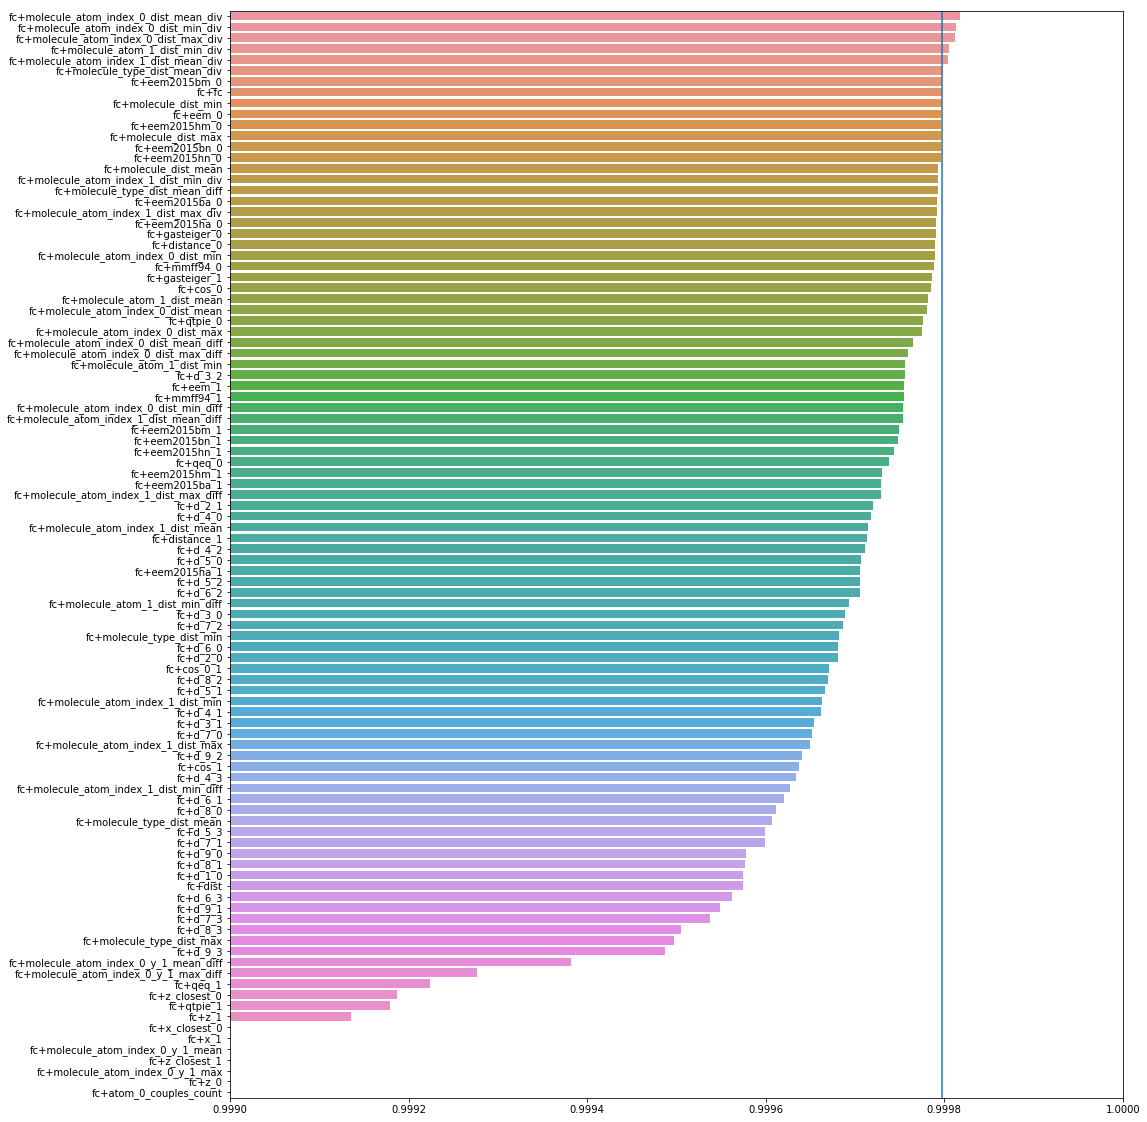

In [92]:
# plot
plt.figure(figsize=(16, 20))
x_ = corr_sum[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
plt.xlim(0.9990, 1.000)
plt.axvline(fc_corr)

<br>
<br>
diff  

In [66]:
# compute
operation = 'dif'
corr_diff = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values - X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_diff[f'fc-{feat}'] = corr
corr_diff = corr_diff.drop(['operation'], axis=1) 

In [94]:
# ranking
cols = corr_diff.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_diff[cols]

,fc-gasteiger_0,fc-molecule_type_dist_min,fc-mmff94_0,fc-eem2015bn_0,fc-eem2015hn_0,fc-molecule_dist_min,fc-eem2015hm_0,fc-eem2015ba_0,fc-eem_0,fc-eem2015ha_0,fc-gasteiger_1,fc-eem2015bm_0,fc-molecule_dist_mean,fc-molecule_atom_index_0_dist_mean,fc-molecule_atom_1_dist_mean,fc-distance_0,fc-molecule_atom_index_0_dist_min,fc-molecule_type_dist_mean_div,fc-molecule_dist_max,fc-eem_1,fc-cos_0,fc-eem2015bn_1,fc-eem2015hn_1,fc-mmff94_1,fc-d_2_1,fc-eem2015hm_1,fc-molecule_atom_index_1_dist_mean,fc-eem2015ba_1,fc-molecule_atom_index_0_dist_max,fc-qeq_0,fc-molecule_atom_index_0_dist_min_div,fc-molecule_type_dist_mean,fc-molecule_type_dist_mean_diff,fc-d_1_0,fc-dist,fc-molecule_atom_1_dist_min,fc-eem2015ha_1,fc-molecule_atom_1_dist_min_div,fc-eem2015bm_1,fc-molecule_atom_index_1_dist_min_div,fc-qtpie_0,fc-d_3_2,fc-molecule_atom_index_1_dist_mean_div,fc-distance_1,fc-molecule_atom_index_0_dist_mean_div,fc-d_2_0,fc-d_4_0,fc-molecule_type_dist_max,fc-molecule_atom_index_1_dist_max,fc-molecule_atom_index_1_dist_min,fc-d_4_1,fc-d_5_0,fc-d_3_1,fc-molecule_atom_index_1_dist_max_div,fc-d_4_2,fc-molecule_atom_index_0_dist_max_div,fc-d_6_0,fc-d_7_0,fc-d_3_0,fc-d_5_1,fc-d_8_0,fc-cos_0_1,fc-d_4_3,fc-d_8_2,fc-molecule_atom_index_1_dist_mean_diff,fc-d_7_2,fc-cos_1,fc-d_6_2,fc-d_6_1,fc-d_5_2,fc-d_9_2,fc-d_9_0,fc-molecule_atom_index_1_dist_max_diff,fc-d_7_1,fc-molecule_atom_index_0_dist_mean_diff,fc-molecule_atom_index_0_dist_min_diff,fc-molecule_atom_index_0_dist_max_diff,fc-d_8_1,fc-d_9_1,fc-molecule_atom_1_dist_min_diff,fc-d_6_3,fc-d_7_3,fc-d_8_3,fc-d_9_3,fc-d_5_3,fc-molecule_atom_index_1_dist_min_diff,fc-molecule_atom_index_0_y_1_mean_diff,fc-molecule_atom_index_0_y_1_max_diff,fc-qtpie_1,fc-z_closest_0,fc-z_1,fc-qeq_1,fc-x_closest_0,fc-x_1,fc-molecule_atom_index_0_y_1_mean,fc-z_closest_1,fc-molecule_atom_index_0_y_1_max,fc-z_0,fc-atom_0_couples_count,fc-x_closest_1
0,0.9998,0.999799,0.999797,0.999797,0.999797,0.999796,0.999796,0.999796,0.999796,0.999796,0.999796,0.999795,0.999793,0.999792,0.999792,0.999792,0.999792,0.999792,0.99979,0.99979,0.999785,0.999783,0.999782,0.99978,0.99978,0.999777,0.999774,0.999773,0.999771,0.99977,0.999768,0.999767,0.999767,0.999761,0.999761,0.999758,0.999756,0.999753,0.999751,0.999749,0.999743,0.999742,0.999736,0.999725,0.999725,0.999717,0.999713,0.999706,0.999705,0.9997,0.999699,0.999689,0.999688,0.999682,0.999674,0.999669,0.999668,0.999655,0.999649,0.999648,0.999638,0.999637,0.999633,0.999629,0.999628,0.999628,0.999628,0.999626,0.999621,0.999614,0.999609,0.999605,0.999598,0.999594,0.99959,0.999568,0.999567,0.999554,0.999521,0.999507,0.999502,0.999499,0.999498,0.999485,0.999479,0.999472,0.999453,0.99934,0.99933,0.999185,0.999129,0.999051,0.998932,0.998881,0.998856,0.998839,0.998818,0.998766,0.998647,0.998583


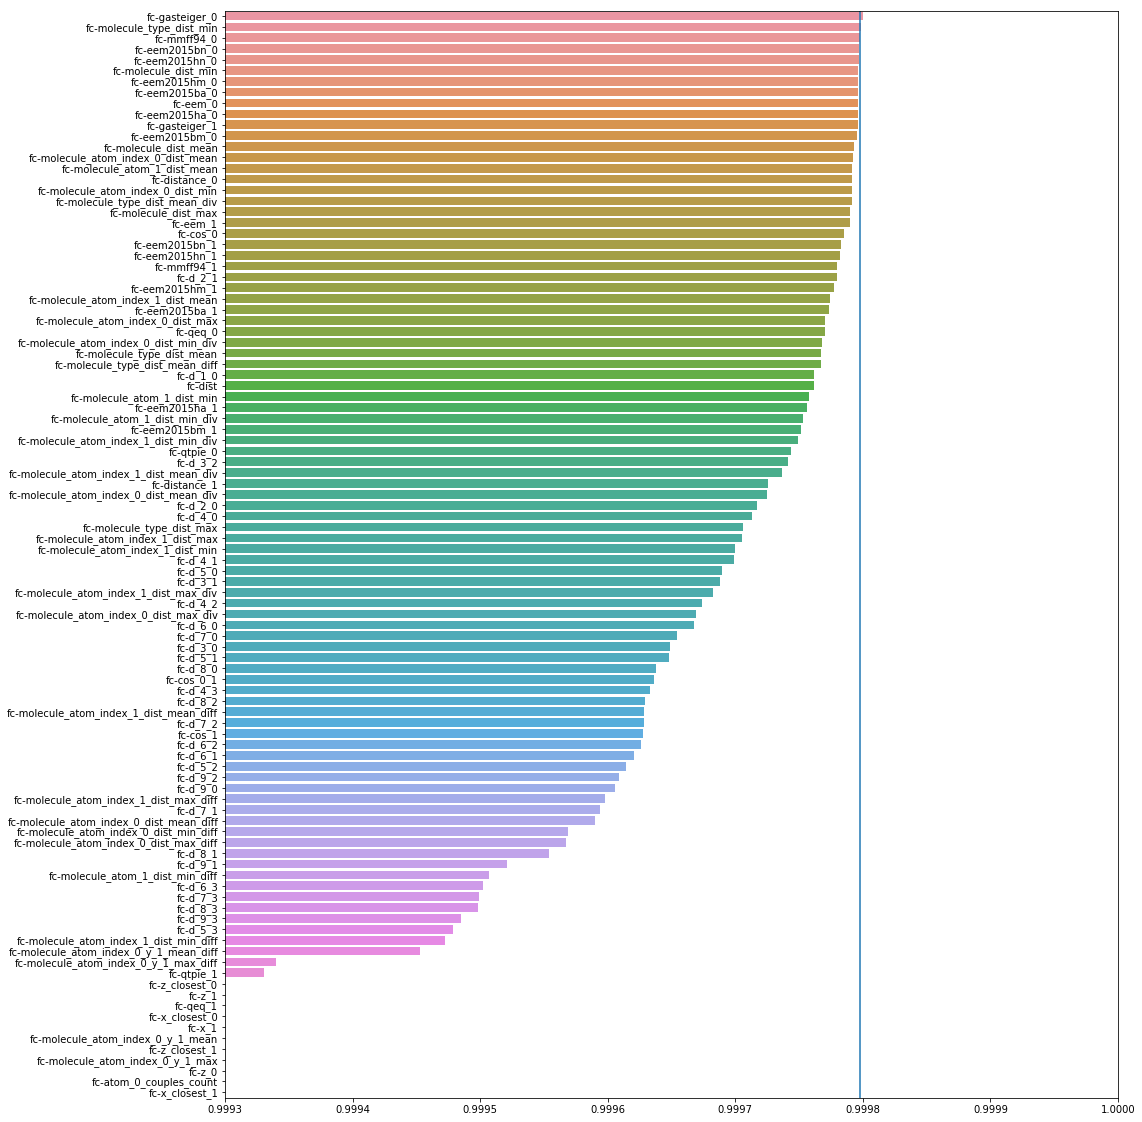

In [95]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_diff[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
plt.xlim(0.9993, 1)
plt.axvline(fc_corr)

<br>
<br>
multi  

In [96]:
# compute
operation = 'multi'
corr_multi = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values * X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_multi[f'fc*{feat}'] = corr
corr_multi = corr_multi.drop(['operation'], axis=1) 

In [97]:
# ranking
cols = corr_multi.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_multi[cols]

,fc*molecule_atom_index_0_dist_min_div,fc*molecule_type_dist_min,fc*molecule_type_dist_mean,fc*dist,fc*d_1_0,fc*molecule_atom_index_0_dist_min_diff,fc*molecule_type_dist_max,fc*molecule_atom_index_0_dist_mean_diff,fc*molecule_atom_index_0_dist_mean_div,fc*molecule_atom_index_0_dist_max_div,fc*molecule_atom_index_0_fc_max_diff,fc*molecule_atom_1_dist_min_div,fc*molecule_atom_1_dist_min_diff,fc*molecule_type_fc_min,fc*molecule_atom_index_0_dist_max_diff,fc*cos_0,fc*molecule_atom_index_0_fc_mean_diff,fc*molecule_atom_index_1_dist_min_diff,fc*molecule_atom_index_1_dist_min_div,fc*molecule_atom_index_0_fc_min_diff,fc*molecule_type_fc_max,fc*fc,fc*molecule_atom_index_1_dist_mean_diff,fc*molecule_atom_index_1_fc_max_diff,fc*molecule_atom_index_1_dist_mean_div,fc*molecule_atom_index_1_dist_max_div,fc*molecule_atom_index_1_fc_min_diff,fc*molecule_atom_index_1_fc_mean_diff,fc*dist_y,fc*molecule_atom_index_1_dist_min,fc*dist_x,fc*molecule_atom_index_1_dist_max_diff,fc*dist_z,fc*d_2_1,fc*molecule_atom_index_1_fc_max,fc*distance_1,fc*d_3_2,fc*d_5_2,fc*d_2_0,fc*d_6_2,fc*molecule_atom_1_dist_min,fc*molecule_atom_index_0_fc_mean_div,fc*d_3_1,fc*d_3_0,fc*d_4_2,fc*cos_1,fc*cos_0_1,fc*molecule_atom_index_1_fc_mean,fc*d_7_2,fc*eem2015bn_1,fc*molecule_atom_index_1_dist_mean,fc*d_8_2,fc*eem2015bm_1,fc*eem2015hn_1,fc*eem2015hm_1,fc*eem_1,fc*d_9_2,fc*atom_index_1,fc*molecule_atom_index_0_fc_max,fc*d_6_1,fc*d_5_1,fc*d_7_1,fc*molecule_atom_index_0_fc_mean,fc*eem2015ba_0,fc*d_4_1,fc*d_5_0,fc*eem2015ha_0,fc*atom_index_closest_1,fc*d_8_1,fc*d_9_1,fc*molecule_atom_index_0_dist_min,fc*distance_0,fc*eem2015ha_1,fc*atom_0_couples_count,fc*d_6_0,fc*d_7_0,fc*qeq_1,fc*molecule_atom_index_1_fc_min,fc*qtpie_1,fc*d_9_0,fc*eem2015hn_0,fc*d_4_0,fc*eem2015bn_0,fc*d_8_0,fc*eem_0,fc*eem2015ba_1,fc*molecule_atom_index_0_y_1_max_diff,fc*molecule_couples,fc*molecule_atom_1_dist_mean,fc*qtpie_0,fc*qeq_0,fc*molecule_atom_index_1_dist_max,fc*atom_1_couples_count,fc*eem2015hm_0,fc*molecule_atom_index_0_fc_min,fc*eem2015bm_0,fc*molecule_atom_index_0_y_1_mean_diff,fc*atom_index_closest_0,fc*gasteiger_0,fc*gasteiger_1
0,0.988457,0.987644,0.986371,0.985929,0.985929,0.984301,0.983387,0.973803,0.972701,0.967953,0.966703,0.965077,0.963617,0.956321,0.956224,0.948854,0.935625,0.928441,0.928278,0.909393,0.908268,0.896991,0.885502,0.878904,0.866533,0.866445,0.865418,0.864101,0.85966,0.835202,0.820544,0.818615,0.811783,0.787362,0.706382,0.694485,0.67276,0.652973,0.644978,0.630653,0.61284,0.607683,0.582209,0.56486,0.543866,0.539024,0.534896,0.532119,0.523272,0.482862,0.475785,0.44298,0.435731,0.425548,0.418466,0.409743,0.409269,0.406955,0.393422,0.386252,0.341223,0.340181,0.336511,0.319081,0.316424,0.313089,0.312318,0.308169,0.288678,0.282304,0.281236,0.281236,0.252281,0.247128,0.24365,0.239203,0.23733,0.229999,0.227298,0.221794,0.219796,0.214382,0.213037,0.212896,0.19961,0.190608,0.171288,0.170081,0.167839,0.160188,0.155503,0.153206,0.152251,0.149387,0.140726,0.119547,0.112688,0.095202,0.089083,0.08885


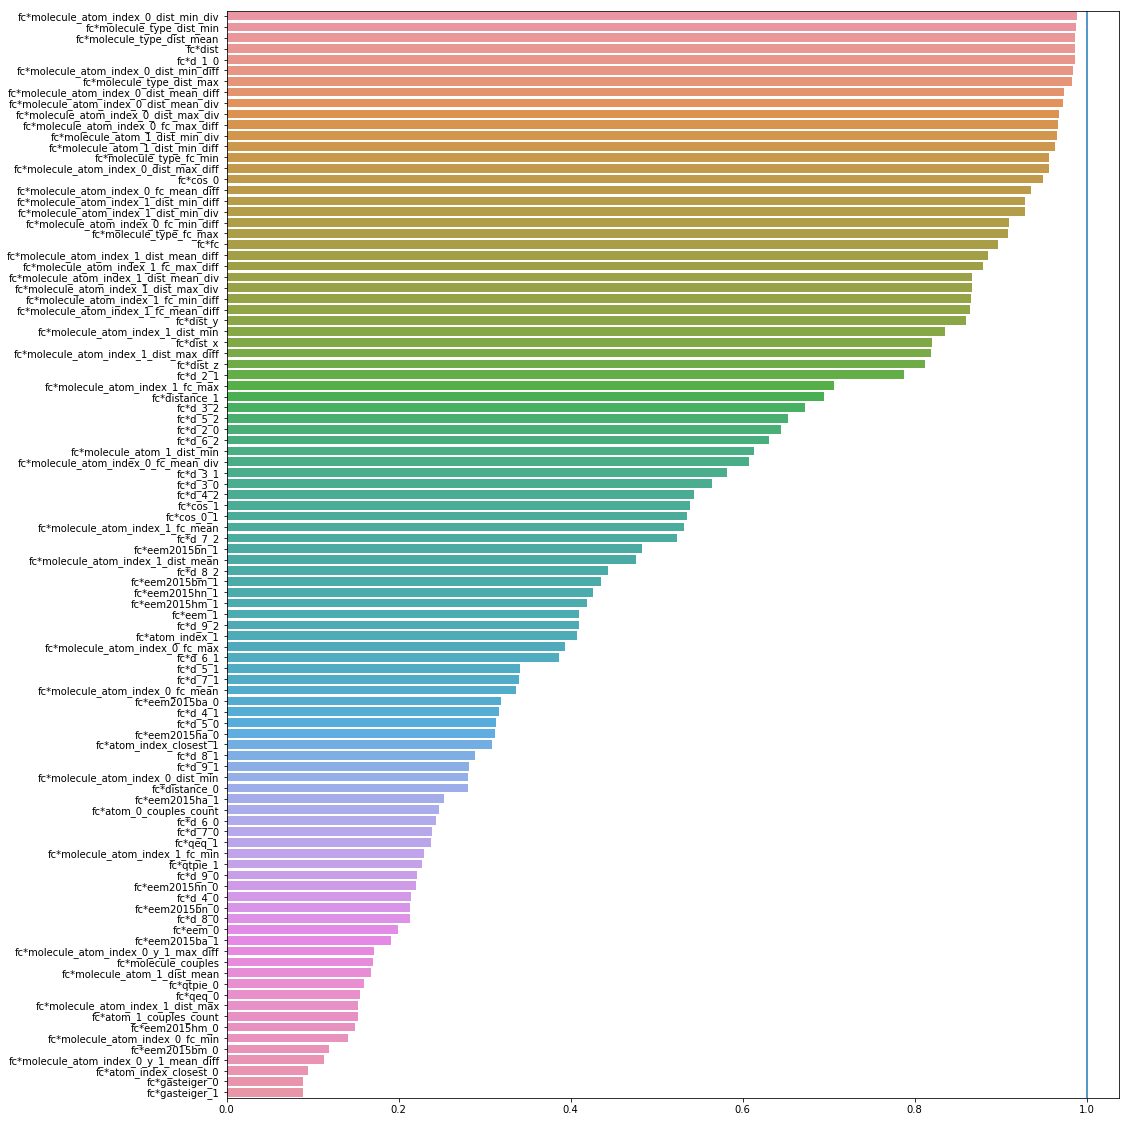

In [98]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_multi[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
# plt.xlim(0.9998, 1)
plt.axvline(fc_corr)

<br>
<br>
div  

In [99]:
# compute
operation = 'div'
corr_div = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values / X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_div[f'fc/{feat}'] = corr
corr_div = corr_div.drop(['operation'], axis=1) 

In [100]:
# ranking
cols = corr_div.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_div[cols]

,fc/d_4_0,fc/d_3_0,fc/d_6_0,fc/molecule_atom_index_0_fc_mean_div,fc/molecule_atom_index_0_fc_mean_diff,fc/molecule_atom_index_0_fc_mean,fc/d_3_2,fc/d_6_2,fc/eem2015bm_0,fc/molecule_type_dist_mean_diff,fc/eem2015bm_1,fc/molecule_type_dist_mean_div,fc/d_7_2,fc/d_4_2,fc/d_5_0,fc/molecule_atom_index_1_dist_mean_diff,fc/cos_0_1,fc/d_8_0,fc/molecule_atom_index_0_dist_mean_diff,fc/dist,fc/d_1_0,fc/molecule_atom_index_0_dist_max_diff,fc/molecule_atom_index_0_dist_min_diff,fc/atom_index_1,fc/molecule_atom_index_0_fc_max,fc/molecule_atom_index_0_fc_max_diff,fc/molecule_type_dist_max,fc/d_9_2,fc/molecule_atom_index_1_dist_max,fc/d_5_2,fc/molecule_atom_index_1_dist_min_diff,fc/molecule_type_dist_min,fc/molecule_type_dist_mean,fc/d_8_2,fc/molecule_atom_index_1_dist_mean_div,fc/molecule_atom_index_0_dist_max_div,fc/d_7_0,fc/molecule_atom_index_0_dist_mean_div,fc/cos_1,fc/molecule_atom_index_1_dist_min_div,fc/molecule_atom_index_0_y_1_mean_diff,fc/molecule_atom_index_0_dist_max,fc/atom_0_couples_count,fc/molecule_atom_index_0_dist_min_div,fc/dist_x,fc/molecule_atom_index_0_y_1_max_diff,fc/molecule_atom_index_1_dist_max_diff,fc/molecule_atom_1_dist_min_diff,fc/dist_y,fc/molecule_atom_index_1_dist_mean,fc/atom_index_closest_1,fc/eem2015ba_0,fc/molecule_atom_index_1_fc_mean,fc/molecule_atom_index_1_fc_mean_diff,fc/d_9_0,fc/gasteiger_1,fc/d_5_3,fc/eem2015ha_0,fc/molecule_atom_1_dist_min,fc/molecule_dist_max,fc/d_2_0,fc/molecule_type_fc_max,fc/molecule_atom_index_1_dist_max_div,fc/atom_index_closest_0,fc/distance_1,fc/eem2015bn_0,fc/d_2_1,fc/molecule_atom_index_1_fc_min,fc/molecule_atom_index_1_fc_min_diff,fc/eem2015hn_0,fc/d_9_3,fc/y_1,fc/molecule_atom_1_dist_min_div,fc/d_8_3,fc/cos_0,fc/molecule_dist_mean,fc/atom_index_0,fc/y_closest_0,fc/atom_1_couples_count,fc/eem2015ba_1,fc/y_0,fc/molecule_type_fc_min,fc/eem2015ha_1,fc/d_5_1,fc/molecule_atom_index_0_fc_min_diff,fc/molecule_atom_index_0_fc_min,fc/d_9_1,fc/eem2015hm_1,fc/molecule_atom_index_0_y_1_max,fc/eem_0,fc/d_4_1,fc/x_closest_1,fc/qtpie_1,fc/d_4_3,fc/dist_z,fc/molecule_atom_index_1_fc_max,fc/molecule_atom_index_1_fc_max_diff,fc/d_7_1,fc/eem_1,fc/x_0
0,0.000537,0.000505,0.000498,0.000492,0.000441,0.000441,0.000437,0.000411,0.000405,0.000362,0.000334,0.000322,0.000316,0.000306,0.000295,0.000265,0.000259,0.000254,0.000248,0.000234,0.000234,0.000222,0.000222,0.000218,0.000203,0.000203,0.000203,0.000198,0.000196,0.000193,0.000192,0.000192,0.000185,0.000185,0.000183,0.000175,0.000174,0.000173,0.000165,0.000153,0.000151,0.000149,0.000139,0.000138,0.000131,0.00013,0.00013,0.000129,0.000127,0.000125,0.000123,0.000122,0.000122,0.000122,0.000122,0.000119,0.000117,0.000114,0.000113,0.000111,0.000107,0.000106,0.000104,0.000103,0.000098,0.000096,0.000092,0.000085,0.000085,0.000081,0.000068,0.000066,0.000063,0.000061,0.000059,0.000059,0.000058,0.000057,0.000055,0.000054,0.000054,0.000053,0.000052,0.000051,0.000049,0.000049,0.000047,0.000044,0.000044,0.000043,0.000042,0.000042,0.000038,0.000034,0.000031,0.000031,0.000031,0.00003,0.000029,0.000028


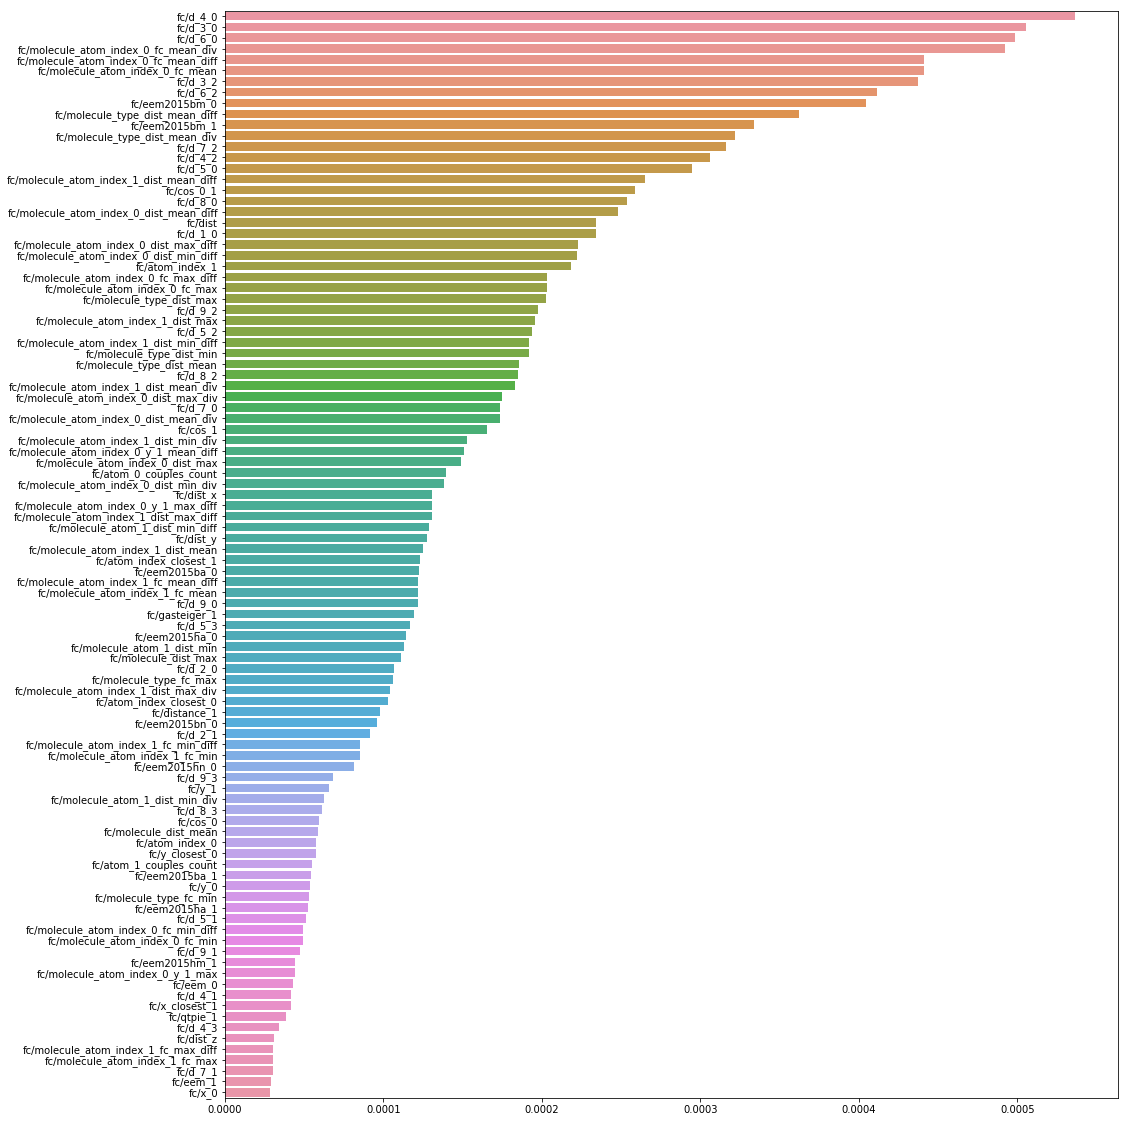

In [116]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_div[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
# plt.xlim(0.9998, 1)
# plt.axvline(fc_corr)

# 標準化あり

In [102]:
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
print(f'fcとscalar_coupling_constantの相関係数: {fc_corr}')

fcとscalar_coupling_constantの相関係数: 0.9997973511920076


<br>
<br>
<br>
標準化

In [103]:
feats = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X = pd.DataFrame(X, columns=feats)
X_test = pd.DataFrame(X_test, columns=feats)

<br>
<br>
sum  

In [104]:
# compute
operation = 'sum'
corr_sum_std = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values + X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_sum_std[f'fc+{feat}'] = corr
corr_sum_std = corr_sum_std.drop(['operation'], axis=1) 

In [105]:
# ranking
cols = corr_sum_std.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_sum_std[cols]

,fc+fc,fc+molecule_type_fc_min,fc+molecule_type_fc_max,fc+molecule_atom_index_0_dist_mean_div,fc+molecule_atom_index_0_dist_max_div,fc+molecule_atom_index_1_dist_max_div,fc+molecule_atom_index_0_dist_min_div,fc+molecule_atom_index_1_dist_mean_div,fc+molecule_atom_index_0_fc_mean_div,fc+molecule_atom_index_0_dist_mean_diff,fc+molecule_atom_index_1_dist_max_diff,fc+molecule_atom_index_0_dist_max_diff,fc+molecule_atom_index_0_dist_min_diff,fc+molecule_atom_index_1_dist_mean_diff,fc+molecule_atom_1_dist_min_div,fc+molecule_atom_index_1_fc_mean,fc+molecule_atom_1_dist_min_diff,fc+d_3_2,fc+d_5_2,fc+d_6_2,fc+molecule_atom_index_1_dist_min_div,fc+molecule_atom_index_1_fc_max,fc+molecule_atom_index_1_dist_min_diff,fc+d_7_2,fc+d_4_2,fc+molecule_atom_index_1_fc_min,fc+d_2_0,fc+d_8_2,fc+d_9_2,fc+cos_1,fc+molecule_atom_index_0_fc_mean,fc+qeq_1,fc+d_3_0,fc+atom_index_closest_1,fc+molecule_atom_index_0_fc_max,fc+d_6_1,fc+d_5_1,fc+molecule_atom_index_0_fc_min,fc+d_7_1,fc+d_5_0,fc+d_9_0,fc+d_8_0,fc+d_7_0,fc+qeq_0,fc+d_9_1,fc+eem2015ha_1,fc+d_8_1,fc+d_6_0,fc+d_4_0,fc+mmff94_1,fc+atom_index_closest_0,fc+eem2015bm_0,fc+y_1,fc+eem2015ba_1,fc+gasteiger_0,fc+atom_1_couples_count,fc+atom_index_0,fc+y_closest_1,fc+molecule_atom_index_1_dist_max,fc+molecule_atom_index_0_dist_max,fc+x_closest_1,fc+x_1,fc+z_0,fc+d_5_3,fc+z_closest_1,fc+molecule_atom_index_0_fc_min_div,fc+molecule_atom_index_1_fc_mean_div,fc+molecule_atom_index_1_fc_max_div,fc+molecule_atom_index_0_fc_max_div,fc+molecule_atom_index_1_fc_min_div,fc+z_closest_0,fc+x_closest_0,fc+d_6_3,fc+molecule_atom_index_0_y_1_mean,fc+molecule_dist_max,fc+x_0,fc+molecule_dist_min,fc+z_1,fc+mmff94_0,fc+y_closest_0,fc+y_0,fc+d_7_3,fc+molecule_atom_index_0_y_1_max,fc+molecule_type_dist_mean_diff,fc+molecule_atom_index_0_dist_mean,fc+molecule_dist_mean,fc+d_8_3,fc+molecule_type_dist_mean_div,fc+eem2015hm_0,fc+d_4_3,fc+molecule_atom_index_0_y_1_mean_diff,fc+eem_0,fc+molecule_couples,fc+molecule_atom_1_dist_mean,fc+eem2015hn_0,fc+eem2015bn_0,fc+gasteiger_1,fc+d_9_3,fc+molecule_atom_index_0_y_1_max_diff,fc+distance_0
0,0.999797,0.994309,0.988645,0.965331,0.962352,0.956446,0.956003,0.949777,0.927729,0.917384,0.913771,0.912842,0.909955,0.902504,0.89365,0.877485,0.872196,0.860721,0.853643,0.846646,0.841372,0.836735,0.831139,0.822496,0.815992,0.811009,0.80764,0.805278,0.794736,0.784326,0.77899,0.775886,0.774727,0.769765,0.758033,0.745283,0.739219,0.736527,0.736009,0.735645,0.731871,0.730008,0.729215,0.728427,0.726743,0.726335,0.72588,0.724543,0.723459,0.721091,0.716921,0.716074,0.714685,0.714658,0.714276,0.713898,0.713548,0.712978,0.712174,0.709752,0.709486,0.70872,0.708655,0.707861,0.707345,0.707035,0.706972,0.706967,0.706931,0.706872,0.706833,0.706798,0.706018,0.705833,0.705787,0.704831,0.704586,0.704238,0.704114,0.703626,0.702461,0.702279,0.700752,0.700085,0.697424,0.694778,0.692657,0.692327,0.691902,0.691479,0.69055,0.68926,0.688883,0.687992,0.687685,0.687626,0.687201,0.686947,0.685203,0.685115


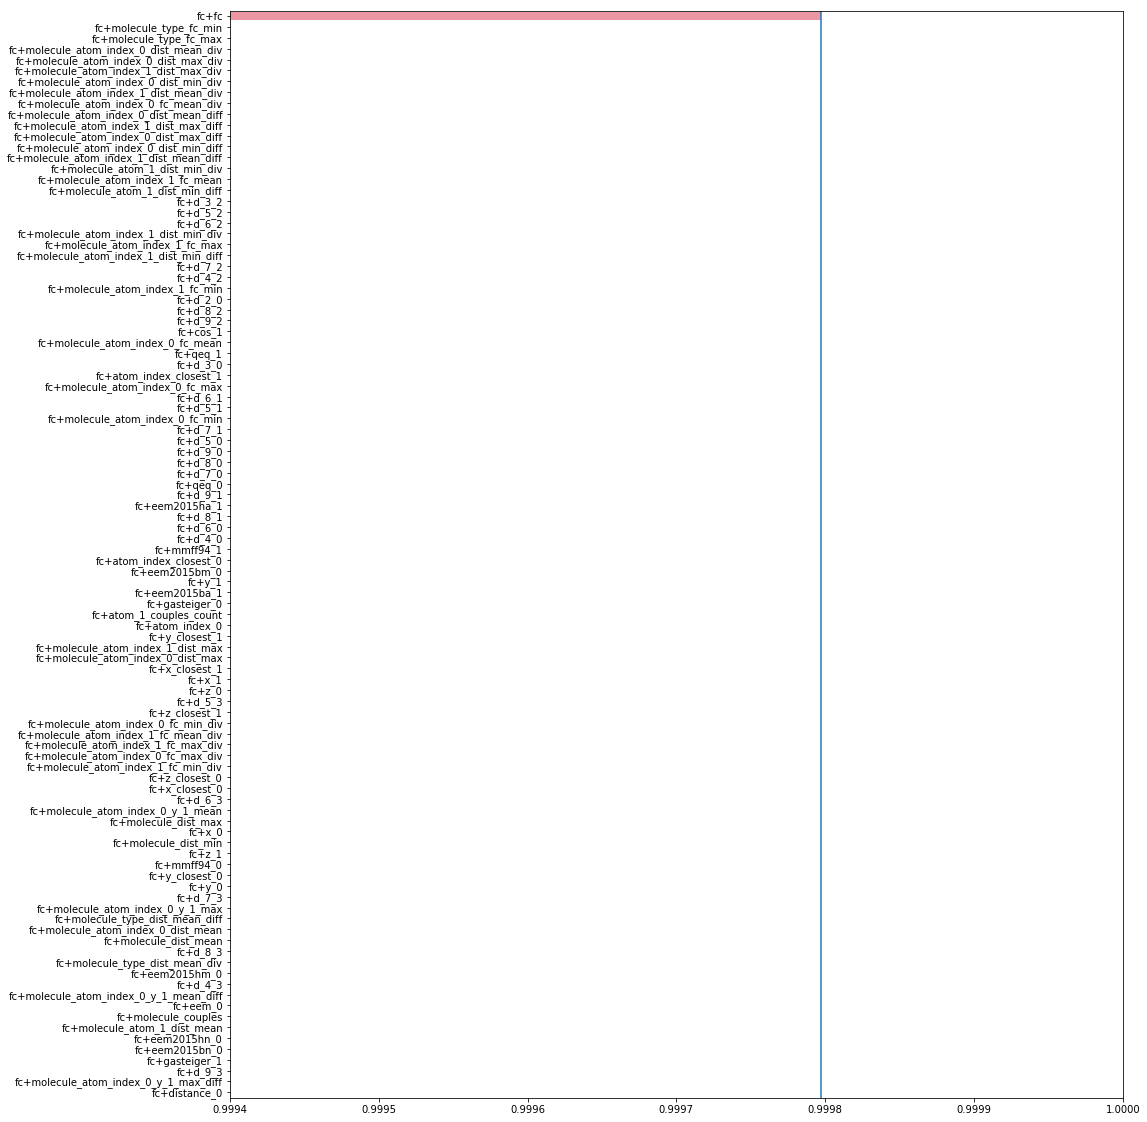

In [106]:
# plot
plt.figure(figsize=(16, 20))
x_ = corr_sum_std[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
plt.xlim(0.9994, 1.000)
plt.axvline(fc_corr)

<br>
<br>
diff  

In [107]:
# compute
operation = 'dif'
corr_diff_std = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values - X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_diff_std[f'fc-{feat}'] = corr
corr_diff_std = corr_diff_std.drop(['operation'], axis=1) 

In [119]:
# ranking
cols = corr_diff_std.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_diff_std[cols]

,fc-molecule_atom_index_0_fc_min_diff,fc-molecule_atom_index_0_fc_mean_diff,fc-molecule_atom_index_1_fc_min_diff,fc-molecule_atom_index_1_fc_mean_diff,fc-molecule_atom_index_0_fc_max_diff,fc-molecule_type_dist_min,fc-molecule_type_dist_mean,fc-dist,fc-d_1_0,fc-molecule_type_dist_max,fc-cos_0,fc-molecule_atom_index_1_fc_max_diff,fc-eem2015bn_1,fc-molecule_atom_index_1_dist_min,fc-eem2015bm_1,fc-d_2_1,fc-d_3_1,fc-eem2015hn_1,fc-dist_y,fc-eem_1,fc-eem2015hm_1,fc-cos_0_1,fc-molecule_atom_index_1_dist_mean,fc-dist_x,fc-molecule_atom_1_dist_min,fc-dist_z,fc-atom_index_1,fc-d_4_1,fc-distance_1,fc-qtpie_1,fc-atom_0_couples_count,fc-eem2015ba_0,fc-qtpie_0,fc-eem2015ha_0,fc-molecule_atom_index_0_dist_min,fc-distance_0,fc-molecule_atom_index_0_y_1_max_diff,fc-d_9_3,fc-gasteiger_1,fc-eem2015bn_0,fc-eem2015hn_0,fc-molecule_atom_1_dist_mean,fc-molecule_couples,fc-eem_0,fc-molecule_atom_index_0_y_1_mean_diff,fc-d_4_3,fc-eem2015hm_0,fc-molecule_type_dist_mean_div,fc-d_8_3,fc-molecule_dist_mean,fc-molecule_atom_index_0_dist_mean,fc-molecule_type_dist_mean_diff,fc-molecule_atom_index_0_y_1_max,fc-d_7_3,fc-y_0,fc-y_closest_0,fc-mmff94_0,fc-z_1,fc-molecule_dist_min,fc-x_0,fc-molecule_dist_max,fc-molecule_atom_index_0_y_1_mean,fc-d_6_3,fc-x_closest_0,fc-z_closest_0,fc-molecule_atom_index_1_fc_min_div,fc-molecule_atom_index_0_fc_max_div,fc-molecule_atom_index_1_fc_max_div,fc-molecule_atom_index_1_fc_mean_div,fc-molecule_atom_index_0_fc_min_div,fc-z_closest_1,fc-d_5_3,fc-z_0,fc-x_1,fc-x_closest_1,fc-molecule_atom_index_0_dist_max,fc-molecule_atom_index_1_dist_max,fc-y_closest_1,fc-atom_index_0,fc-atom_1_couples_count,fc-gasteiger_0,fc-eem2015ba_1,fc-y_1,fc-eem2015bm_0,fc-atom_index_closest_0,fc-mmff94_1,fc-d_4_0,fc-d_6_0,fc-d_8_1,fc-eem2015ha_1,fc-d_9_1,fc-qeq_0,fc-d_7_0,fc-d_8_0,fc-d_9_0,fc-d_5_0,fc-d_7_1,fc-molecule_atom_index_0_fc_min,fc-d_5_1,fc-d_6_1
0,0.996855,0.993984,0.987997,0.95931,0.952273,0.93671,0.923187,0.914419,0.914419,0.909237,0.867429,0.822701,0.814726,0.814065,0.811065,0.808575,0.803931,0.802888,0.801504,0.8,0.796748,0.794798,0.791795,0.791403,0.791054,0.789569,0.780715,0.779915,0.775362,0.774521,0.740828,0.730768,0.729056,0.728977,0.728157,0.728157,0.728074,0.726429,0.72619,0.725786,0.72573,0.725439,0.724595,0.724234,0.723005,0.722116,0.721711,0.721305,0.720987,0.718942,0.716377,0.713779,0.713121,0.711618,0.711437,0.710285,0.709804,0.709678,0.709334,0.709089,0.708139,0.708093,0.707909,0.707129,0.707094,0.707055,0.706996,0.706959,0.706955,0.706892,0.706582,0.70607,0.705268,0.705203,0.704432,0.704164,0.701716,0.700898,0.700317,0.69996,0.699578,0.699188,0.699157,0.697735,0.696864,0.69255,0.690074,0.688936,0.687527,0.68705,0.686614,0.68483,0.683988,0.683143,0.681147,0.677068,0.676673,0.676114,0.673164,0.666444


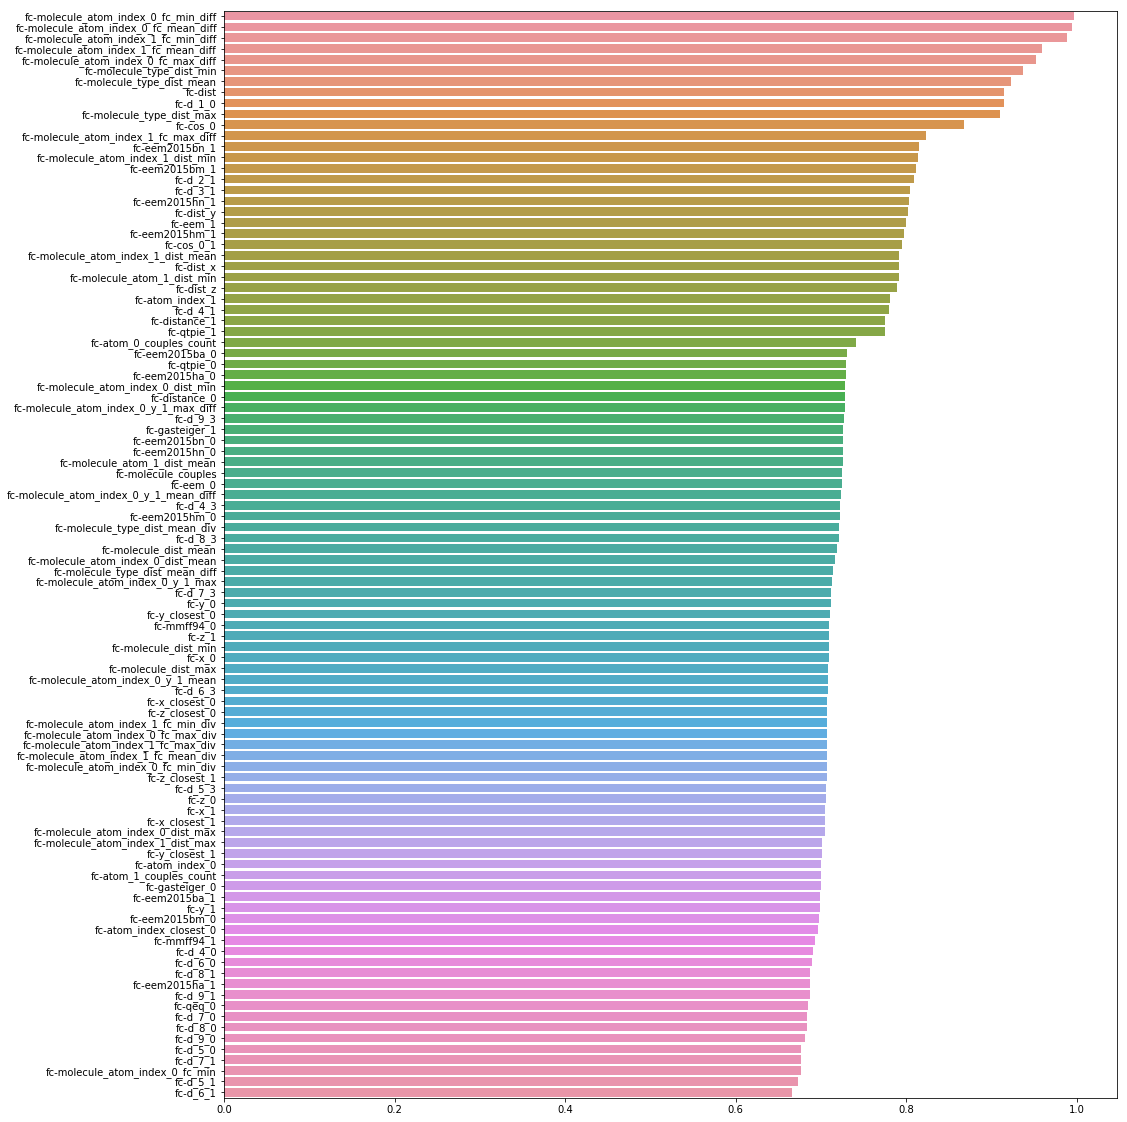

In [121]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_diff_std[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
# plt.xlim(0.9993, 1)
# plt.axvline(fc_corr)

<br>
<br>
multi  

In [110]:
# compute
operation = 'multi'
corr_multi_std = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values * X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_multi_std[f'fc*{feat}'] = corr
corr_multi_std = corr_multi_std.drop(['operation'], axis=1) 

In [111]:
# ranking
cols = corr_multi_std.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_multi_std[cols]

,fc*molecule_atom_index_0_dist_min_div,fc*molecule_type_dist_min,fc*molecule_type_dist_mean,fc*dist,fc*d_1_0,fc*molecule_atom_index_0_dist_min_diff,fc*molecule_type_dist_max,fc*molecule_atom_index_0_dist_mean_diff,fc*molecule_atom_index_0_dist_mean_div,fc*molecule_atom_index_0_dist_max_div,fc*molecule_atom_index_0_fc_max_diff,fc*molecule_atom_1_dist_min_div,fc*molecule_atom_1_dist_min_diff,fc*molecule_type_fc_min,fc*molecule_atom_index_0_dist_max_diff,fc*cos_0,fc*molecule_atom_index_0_fc_mean_diff,fc*molecule_atom_index_1_dist_min_diff,fc*molecule_atom_index_1_dist_min_div,fc*molecule_atom_index_0_fc_min_diff,fc*molecule_type_fc_max,fc*fc,fc*molecule_atom_index_1_dist_mean_diff,fc*molecule_atom_index_1_fc_max_diff,fc*molecule_atom_index_1_dist_mean_div,fc*molecule_atom_index_1_dist_max_div,fc*molecule_atom_index_1_fc_min_diff,fc*molecule_atom_index_1_fc_mean_diff,fc*dist_y,fc*molecule_atom_index_1_dist_min,fc*dist_x,fc*molecule_atom_index_1_dist_max_diff,fc*dist_z,fc*d_2_1,fc*molecule_atom_index_1_fc_max,fc*distance_1,fc*d_3_2,fc*d_5_2,fc*d_2_0,fc*d_6_2,fc*molecule_atom_1_dist_min,fc*molecule_atom_index_0_fc_mean_div,fc*d_3_1,fc*d_3_0,fc*d_4_2,fc*cos_1,fc*cos_0_1,fc*molecule_atom_index_1_fc_mean,fc*d_7_2,fc*eem2015bn_1,fc*molecule_atom_index_1_dist_mean,fc*d_8_2,fc*eem2015bm_1,fc*eem2015hn_1,fc*eem2015hm_1,fc*eem_1,fc*d_9_2,fc*atom_index_1,fc*molecule_atom_index_0_fc_max,fc*d_6_1,fc*d_5_1,fc*d_7_1,fc*molecule_atom_index_0_fc_mean,fc*eem2015ba_0,fc*d_4_1,fc*d_5_0,fc*eem2015ha_0,fc*atom_index_closest_1,fc*d_8_1,fc*d_9_1,fc*molecule_atom_index_0_dist_min,fc*distance_0,fc*eem2015ha_1,fc*atom_0_couples_count,fc*d_6_0,fc*d_7_0,fc*qeq_1,fc*molecule_atom_index_1_fc_min,fc*qtpie_1,fc*d_9_0,fc*eem2015hn_0,fc*d_4_0,fc*eem2015bn_0,fc*d_8_0,fc*eem_0,fc*eem2015ba_1,fc*molecule_atom_index_0_y_1_max_diff,fc*molecule_couples,fc*molecule_atom_1_dist_mean,fc*qtpie_0,fc*qeq_0,fc*molecule_atom_index_1_dist_max,fc*atom_1_couples_count,fc*eem2015hm_0,fc*molecule_atom_index_0_fc_min,fc*eem2015bm_0,fc*molecule_atom_index_0_y_1_mean_diff,fc*atom_index_closest_0,fc*gasteiger_0,fc*gasteiger_1
0,0.988457,0.987644,0.986371,0.985929,0.985929,0.984301,0.983387,0.973803,0.972701,0.967953,0.966703,0.965077,0.963617,0.956321,0.956224,0.948854,0.935625,0.928441,0.928278,0.909393,0.908268,0.896991,0.885502,0.878904,0.866533,0.866445,0.865418,0.864101,0.85966,0.835202,0.820544,0.818615,0.811783,0.787362,0.706382,0.694485,0.67276,0.652973,0.644978,0.630653,0.61284,0.607683,0.582209,0.56486,0.543866,0.539024,0.534896,0.532119,0.523272,0.482862,0.475785,0.44298,0.435731,0.425548,0.418466,0.409743,0.409269,0.406955,0.393422,0.386252,0.341223,0.340181,0.336511,0.319081,0.316424,0.313089,0.312318,0.308169,0.288678,0.282304,0.281236,0.281236,0.252281,0.247128,0.24365,0.239203,0.23733,0.229999,0.227298,0.221794,0.219796,0.214382,0.213037,0.212896,0.19961,0.190608,0.171288,0.170081,0.167839,0.160188,0.155503,0.153206,0.152251,0.149387,0.140726,0.119547,0.112688,0.095202,0.089083,0.08885


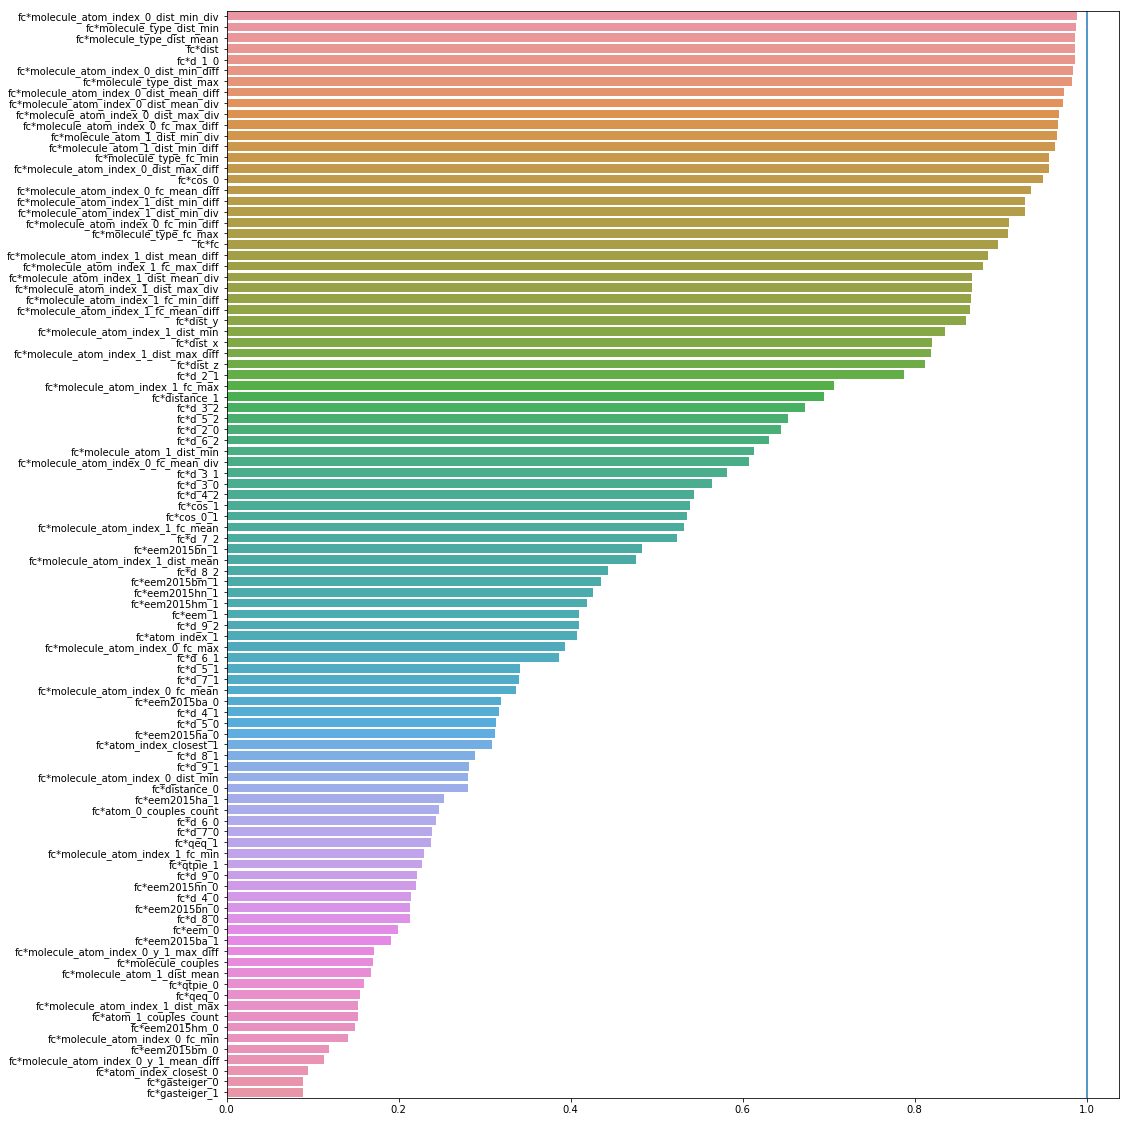

In [112]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_multi_std[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
# plt.xlim(0.9998, 1)
plt.axvline(fc_corr)

<br>
<br>
div  

In [113]:
# compute
operation = 'div'
corr_div_std = pd.DataFrame({'operation': [operation]})
for feat in progress_bar(X.columns):
    new_feat = X[feat].values / X.fc.values
    corr = np.abs(np.corrcoef(new_feat, y)[0, 1])
    corr_div_std[f'fc/{feat}'] = corr
corr_div_std = corr_div_std.drop(['operation'], axis=1) 

In [114]:
# ranking
cols = corr_div_std.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:100]
corr_div_std[cols]

,fc/d_4_0,fc/d_3_0,fc/d_6_0,fc/molecule_atom_index_0_fc_mean_div,fc/molecule_atom_index_0_fc_mean_diff,fc/molecule_atom_index_0_fc_mean,fc/d_3_2,fc/d_6_2,fc/eem2015bm_0,fc/molecule_type_dist_mean_diff,fc/eem2015bm_1,fc/molecule_type_dist_mean_div,fc/d_7_2,fc/d_4_2,fc/d_5_0,fc/molecule_atom_index_1_dist_mean_diff,fc/cos_0_1,fc/d_8_0,fc/molecule_atom_index_0_dist_mean_diff,fc/dist,fc/d_1_0,fc/molecule_atom_index_0_dist_max_diff,fc/molecule_atom_index_0_dist_min_diff,fc/atom_index_1,fc/molecule_atom_index_0_fc_max_diff,fc/molecule_atom_index_0_fc_max,fc/molecule_type_dist_max,fc/d_9_2,fc/molecule_atom_index_1_dist_max,fc/d_5_2,fc/molecule_atom_index_1_dist_min_diff,fc/molecule_type_dist_min,fc/molecule_type_dist_mean,fc/d_8_2,fc/molecule_atom_index_1_dist_mean_div,fc/molecule_atom_index_0_dist_max_div,fc/d_7_0,fc/molecule_atom_index_0_dist_mean_div,fc/cos_1,fc/molecule_atom_index_1_dist_min_div,fc/molecule_atom_index_0_y_1_mean_diff,fc/molecule_atom_index_0_dist_max,fc/atom_0_couples_count,fc/molecule_atom_index_0_dist_min_div,fc/dist_x,fc/molecule_atom_index_0_y_1_max_diff,fc/molecule_atom_index_1_dist_max_diff,fc/molecule_atom_1_dist_min_diff,fc/dist_y,fc/molecule_atom_index_1_dist_mean,fc/atom_index_closest_1,fc/eem2015ba_0,fc/molecule_atom_index_1_fc_mean_diff,fc/molecule_atom_index_1_fc_mean,fc/d_9_0,fc/gasteiger_1,fc/d_5_3,fc/eem2015ha_0,fc/molecule_atom_1_dist_min,fc/molecule_dist_max,fc/d_2_0,fc/molecule_type_fc_max,fc/molecule_atom_index_1_dist_max_div,fc/atom_index_closest_0,fc/distance_1,fc/eem2015bn_0,fc/d_2_1,fc/molecule_atom_index_1_fc_min_diff,fc/molecule_atom_index_1_fc_min,fc/eem2015hn_0,fc/d_9_3,fc/y_1,fc/molecule_atom_1_dist_min_div,fc/d_8_3,fc/cos_0,fc/molecule_dist_mean,fc/atom_index_0,fc/y_closest_0,fc/atom_1_couples_count,fc/eem2015ba_1,fc/y_0,fc/molecule_type_fc_min,fc/eem2015ha_1,fc/d_5_1,fc/molecule_atom_index_0_fc_min_diff,fc/molecule_atom_index_0_fc_min,fc/d_9_1,fc/eem2015hm_1,fc/molecule_atom_index_0_y_1_max,fc/eem_0,fc/d_4_1,fc/x_closest_1,fc/qtpie_1,fc/d_4_3,fc/dist_z,fc/molecule_atom_index_1_fc_max_diff,fc/molecule_atom_index_1_fc_max,fc/d_7_1,fc/eem_1,fc/x_0
0,0.000537,0.000505,0.000498,0.000492,0.000441,0.000441,0.000437,0.000411,0.000405,0.000362,0.000334,0.000322,0.000316,0.000306,0.000295,0.000265,0.000259,0.000254,0.000248,0.000234,0.000234,0.000222,0.000222,0.000218,0.000203,0.000203,0.000203,0.000198,0.000196,0.000193,0.000192,0.000192,0.000185,0.000185,0.000183,0.000175,0.000174,0.000173,0.000165,0.000153,0.000151,0.000149,0.000139,0.000138,0.000131,0.00013,0.00013,0.000129,0.000127,0.000125,0.000123,0.000122,0.000122,0.000122,0.000122,0.000119,0.000117,0.000114,0.000113,0.000111,0.000107,0.000106,0.000104,0.000103,0.000098,0.000096,0.000092,0.000085,0.000085,0.000081,0.000068,0.000066,0.000063,0.000061,0.000059,0.000059,0.000058,0.000057,0.000055,0.000054,0.000054,0.000053,0.000052,0.000051,0.000049,0.000049,0.000047,0.000044,0.000044,0.000043,0.000042,0.000042,0.000038,0.000034,0.000031,0.000031,0.000031,0.00003,0.000029,0.000028


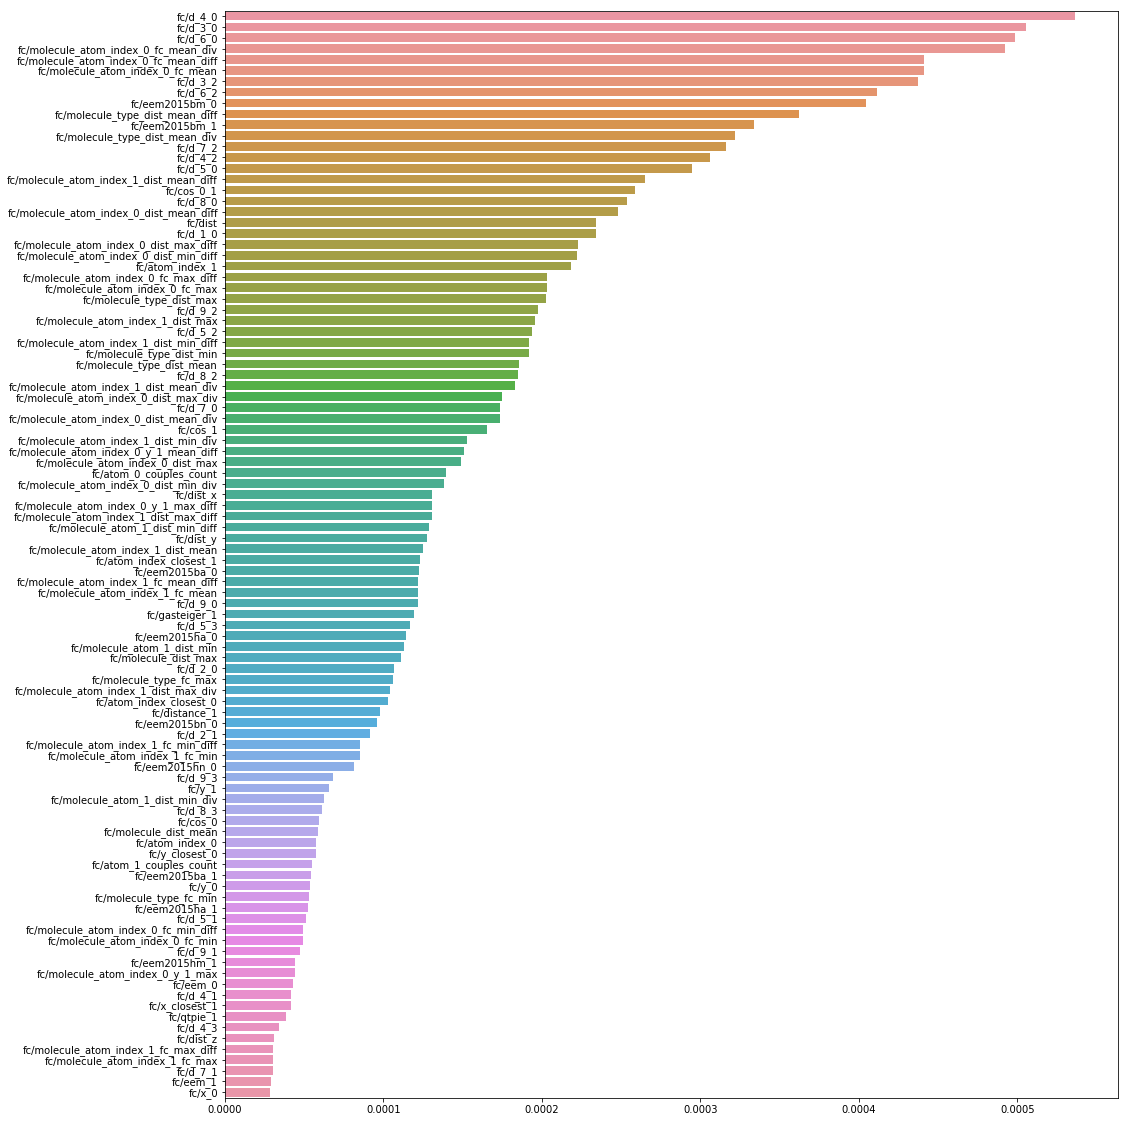

In [118]:
# plot
plt.figure(figsize=(16, 20))
fc_corr = np.corrcoef(y, X.fc.values)[0, 1]
x_ = corr_div_std[cols].sort_values(axis=1, by=0, ascending=False).iloc[0, :].values
y_ = cols
sns.barplot(x=x_, y=y_, label=None)
# plt.axvline(fc_corr)
# plt.xlim(0.9998, 1)

# Result and Discussion
- 標準化しないほうが、精度がよかった。
- 全体として、いい成果はでなかった。
- fcをそのまま使うだけのほうがよさそうだ。

- sum

In [122]:
cols = corr_sum.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:10+1]
best_feats_sum = list(corr_sum[cols])
best_feats_sum

['fc+molecule_atom_index_0_dist_mean_div',
 'fc+molecule_atom_index_0_dist_min_div',
 'fc+molecule_atom_index_0_dist_max_div',
 'fc+molecule_atom_1_dist_min_div',
 'fc+molecule_atom_index_1_dist_mean_div',
 'fc+molecule_type_dist_mean_div',
 'fc+eem2015bm_0',
 'fc+fc',
 'fc+molecule_dist_min',
 'fc+eem_0',
 'fc+eem2015hm_0']

In [126]:
feats_sum =  [
 'molecule_atom_index_0_dist_mean_div',
 'molecule_atom_index_0_dist_min_div',
 'molecule_atom_index_0_dist_max_div',
 'molecule_atom_1_dist_min_div',
 'molecule_atom_index_1_dist_mean_div',
 'molecule_type_dist_mean_div',
 'eem2015bm_0',
 'molecule_dist_min',
 'eem_0',
 'eem2015hm_0']

<br>
<br>

- diff

In [124]:
cols = corr_diff.sort_values(axis=1, by=0, ascending=False)
cols = list(cols)[:10+1]
best_feats_sum = list(corr_diff[cols])
best_feats_sum

['fc-gasteiger_0',
 'fc-molecule_type_dist_min',
 'fc-mmff94_0',
 'fc-eem2015bn_0',
 'fc-eem2015hn_0',
 'fc-molecule_dist_min',
 'fc-eem2015hm_0',
 'fc-eem2015ba_0',
 'fc-eem_0',
 'fc-eem2015ha_0',
 'fc-gasteiger_1']

In [125]:
feats_diff = [
 'gasteiger_0',
 'molecule_type_dist_min',
 'mmff94_0',
 'eem2015bn_0',
 'eem2015hn_0',
 'molecule_dist_min',
 'eem2015hm_0',
 'eem2015ba_0',
 'eem_0',
 'eem2015ha_0',
 'gasteiger_1']